# fdsreader Module

In order to analyse simulation data computed by FDS with Python, we have developed the Python module fdsreader. It's aim is to read most data output formats generated by FDS and map them to Python data structures.

It is freely available and open source. The source code is hosted at GitHub: [FireDynamics/fdsreader](https://github.com/FireDynamics/fdsreader).

## Installation

The fdsreader module can be installed via pip (see also the GitHub repository):

```
pip install fdsreader
```

However, it is already installed on all JupyterLab instances used for this lecture.

## Demo Data Set

To demonstrate the usage of the fdsreader module, a simple FDS scenario is utilized:

```{literalinclude} ../../../../data/fdsreader/example_01/example_01.fds
```

## Open a Data Set

First the fdsreader module needs to be loaded:

In [1]:
import fdsreader

The version of (any) the module can be checked with:

In [2]:
print(fdsreader.__version__)

1.1.0rc1


Next, the reader needs to be pointed to the directory, which contains the simulation data, especailly the smokeview file:

In [3]:
# define the path to the data
path_to_data = '../../../../data/fdsreader/example_01/rundir'

sim = fdsreader.Simulation(path_to_data)

```{tip} You can use the autocomplete function in Jupyter.
```

The `Simulation` object `sim` contains now all the information and data about the simulaiton output:

In [4]:
print(sim)

Simulation(chid=output_fdsreader_example,
           meshes=1,
           slices=2,
           devices=6)


It contains information about a single mesh (`MESH`), two slices (`SLCF`) and six point measurements (`DEVC`). The additional device – there were just five defined in the input file – is the time stemp. 

## `DEVC` Data

The simplest data set is the output of the `DEVC` directives. The available data and meta information can be directly printed:

In [5]:
# short reference
devc = sim.devices
print(devc)

{'Time': Device(id='Time', xyz=(0.0, 0.0, 0.0), quantity=Quantity('Time'), mean=5.4907660484313965), 'T_1.0': Device(id='T_1.0', xyz=(0.0, 0.0, 1.0), quantity=Quantity('TEMPERATURE'), mean=804.3012084960938), 'T_2.0': Device(id='T_2.0', xyz=(0.0, 0.0, 2.0), quantity=Quantity('TEMPERATURE'), mean=691.8992919921875), 'T_3.0': Device(id='T_3.0', xyz=(0.0, 0.0, 3.0), quantity=Quantity('TEMPERATURE'), mean=479.3949279785156), 'T_4.0': Device(id='T_4.0', xyz=(0.0, 0.0, 4.0), quantity=Quantity('TEMPERATURE'), mean=334.0716857910156), 'T_5.0': Device(id='T_5.0', xyz=(0.0, 0.0, 5.0), quantity=Quantity('TEMPERATURE'), mean=240.62425231933594)}


In [6]:
for i in devc:
    print(f"ID: {devc[i].id},\t quantity: {devc[i].quantity.quantity},\t position: {devc[i].position}")

ID: Time,	 quantity: Time,	 position: (0.0, 0.0, 0.0)
ID: T_1.0,	 quantity: TEMPERATURE,	 position: (0.0, 0.0, 1.0)
ID: T_2.0,	 quantity: TEMPERATURE,	 position: (0.0, 0.0, 2.0)
ID: T_3.0,	 quantity: TEMPERATURE,	 position: (0.0, 0.0, 3.0)
ID: T_4.0,	 quantity: TEMPERATURE,	 position: (0.0, 0.0, 4.0)
ID: T_5.0,	 quantity: TEMPERATURE,	 position: (0.0, 0.0, 5.0)


```{tip} Autocomplete works also for the dictionary keys ;-)
```
A raw look at the data (`Device.data`), which is stored as a numpy array:

In [7]:
print(type(devc['Time'].data))

<class 'numpy.ndarray'>


In [8]:
print(devc['Time'].data.shape)

(602,)


In [9]:
devc["Time"].data

array([ 0.        ,  0.1       ,  0.2       ,  0.3       ,  0.4       ,
        0.5       ,  0.6       ,  0.7       ,  0.8       ,  0.9       ,
        0.97940284,  1.0490968 ,  1.1105819 ,  1.1720669 ,  1.233552  ,
        1.27252   ,  1.311488  ,  1.3441169 ,  1.3767458 ,  1.4093747 ,
        1.4452664 ,  1.4749194 ,  1.5045723 ,  1.531071  ,  1.5575697 ,
        1.5799627 ,  1.6023557 ,  1.6247487 ,  1.6444938 ,  1.6642389 ,
        1.6839839 ,  1.703729  ,  1.723474  ,  1.7432191 ,  1.7629641 ,
        1.7827092 ,  1.8024544 ,  1.8221993 ,  1.8419445 ,  1.8616894 ,
        1.8814344 ,  1.9011796 ,  1.9209245 ,  1.9406697 ,  1.9604146 ,
        1.9801598 ,  1.9999048 ,  2.01965   ,  2.0393949 ,  2.05914   ,
        2.0748444 ,  2.090549  ,  2.1062534 ,  2.1219578 ,  2.1356995 ,
        2.149441  ,  2.1631825 ,  2.1769242 ,  2.1906657 ,  2.2044075 ,
        2.2181492 ,  2.2318907 ,  2.2456324 ,  2.259374  ,  2.2731154 ,
        2.2868571 ,  2.3005986 ,  2.3143404 ,  2.329456  ,  2.34

The device data can be also visualised with matplotlib:

In [75]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

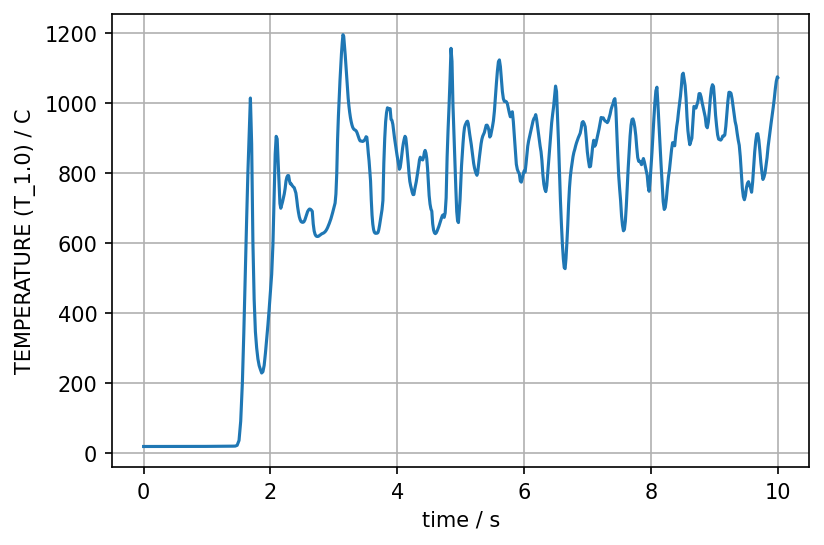

In [76]:
plt.plot(devc['Time'].data, devc['T_1.0'].data)
plt.xlabel("time / s")
devc_id = devc['T_1.0'].id
devc_q = devc['T_1.0'].quantity.quantity
devc_u = devc['T_1.0'].quantity.unit
plt.ylabel(f"{devc_q} ({devc_id}) / {devc_u}")
plt.grid()

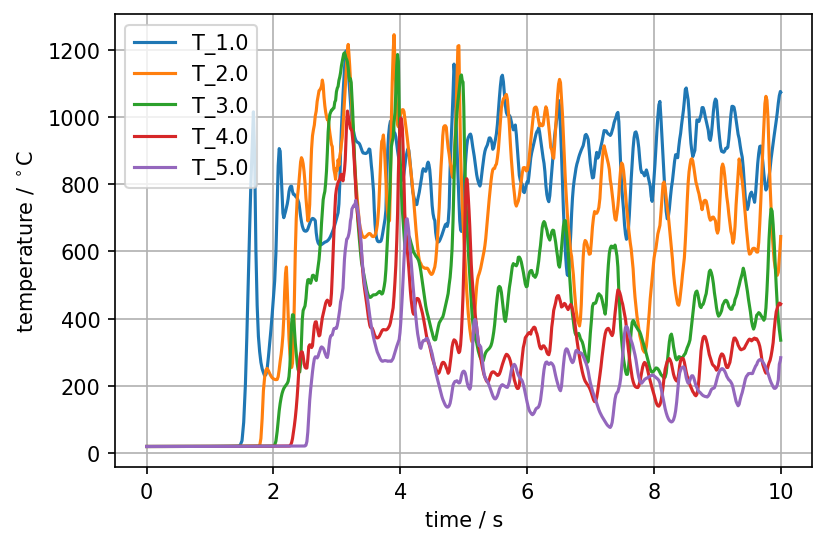

In [77]:
for i in devc:
    
    # consider only devices with an ID that starts with 'T_'
    if not i.startswith('T_'): 
        continue
    
    plt.plot(devc["Time"].data, devc[i].data, label=devc[i].id)
    
plt.legend()
plt.xlabel("time / s")
plt.ylabel('temperature / $^\circ$C')
plt.grid()

## HRR Data

In the same fashion as the `DEVC` data, the data written to the `HRR` file can be directly accessed:

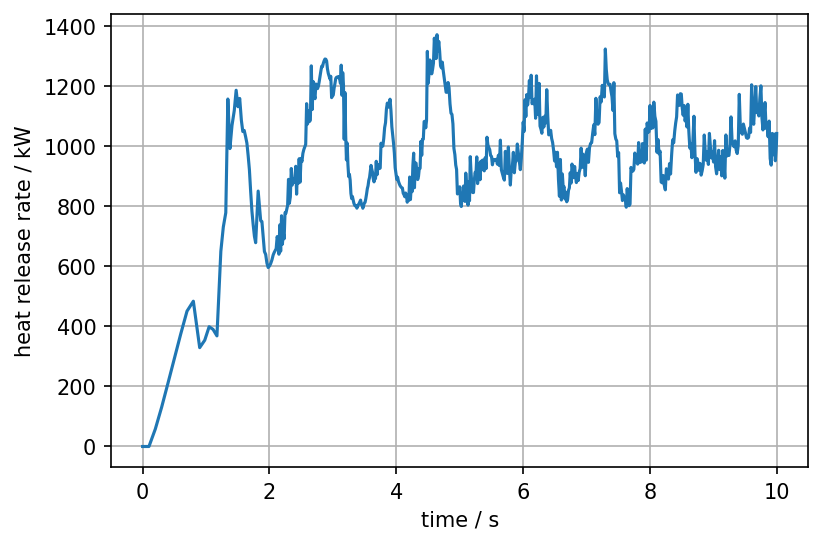

In [78]:
plt.plot(sim.hrr['Time'], sim.hrr['HRR'])
plt.xlabel('time / s')
plt.ylabel('heat release rate / kW')
plt.grid()

## `SLCF` Data

Data generated by `SLCF` directives span over two or three spatial dimensions plus the time dimension. Besides that, they can be distributed across multiple meshes. 

In [23]:
# print available slice data
for slice in sim.slices:
    print(slice.quantity, slice.extent)

Quantity('TEMPERATURE') Extent([-2.50, 2.50] x [0.10, 0.10] x [0.00, 10.00])
Quantity('VELOCITY') Extent([-2.50, 2.50] x [0.10, 0.10] x [0.00, 10.00])


In [31]:
# choose (output) time step, next to t=7.5 s
it = sim.slices[0].get_nearest_timestep(7.5)
print(f"Time step: {it}")
print(f"Simulation time: {sim.slices[0].times[it]}")

Time step: 443
Simulation time: 7.507146


The data of a slice is stored for each mesh individually. In this simple example, there is only a single mesh, yet for formal consistency it still needs to be referred.

The sturcutre is as follows

```
sim.slices[sliceid][meshid].data[timestep, direction1, direction2]
```

where `sliceid` is just the index of the slice, `meshid` is the index of the mesh, here 0, and the reference to the data is given by the time step id and then the two spatial indices.

The following example illustrates the visualisation of the data and steps needed to adjust the representation.

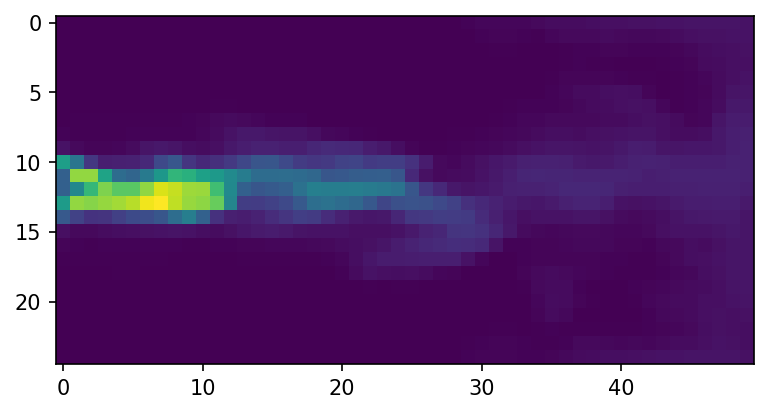

In [38]:
# Initial visualasation of the data
plt.imshow(sim.slices[0][0].data[it]);

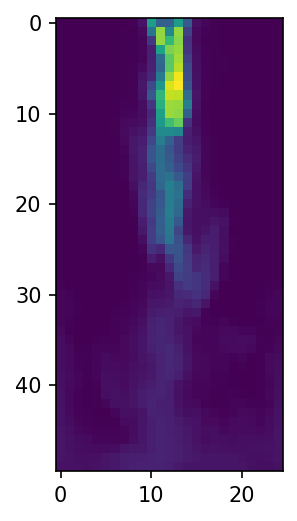

In [41]:
# Access the transpose data using ndarray.T
plt.imshow(sim.slices[0][0].data[it].T);

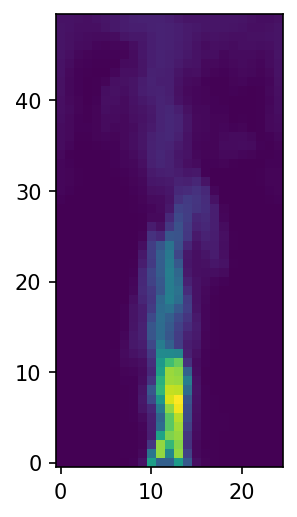

In [43]:
# The default origin of matplotlib's imshow is not suited 
# for our case. Thus the origin is set to 'lower'.
plt.imshow(sim.slices[0][0].data[it].T, origin='lower');

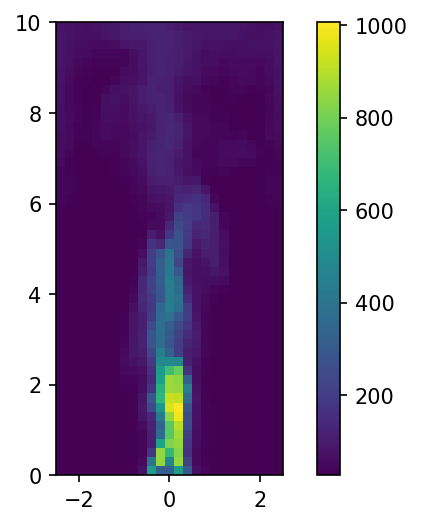

In [46]:
# Finally, also the extend is specified to move from index to physical space
plt.imshow(sim.slices[0][0].data[it].T, 
           origin='lower', 
           extent=sim.slices[0].extent.as_list())
plt.colorbar();

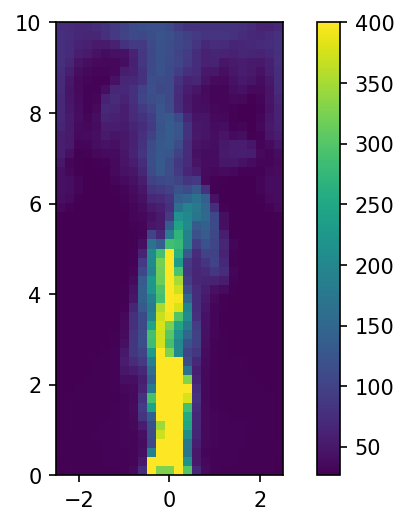

In [49]:
# Example of limiting the shown values
plt.imshow(sim.slices[0][0].data[it].T,
           vmax=400,
           origin='lower', 
           extent=sim.slices[0].extent.as_list())
plt.colorbar();

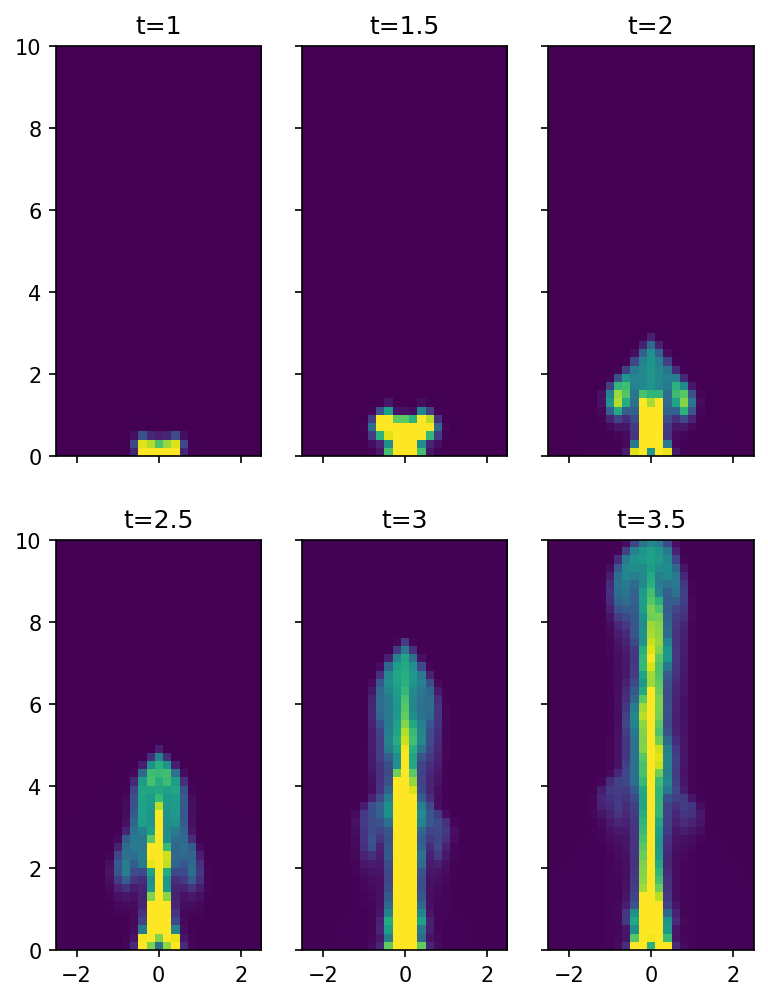

In [56]:
# Example for a multi plot
slice = sim.slices[0]
list_t = [1, 1.5, 2, 2.5, 3, 3.5]
fig, axs = plt.subplots(2,3, figsize=(6,8), sharex=True, sharey=True)
for i in range(len(list_t)):
    it = slice.get_nearest_timestep(list_t[i])
    axs.flat[i].imshow(slice[0].data[it].T,
                       vmin=20,
                       vmax=400,
                       origin='lower', 
                       extent=slice.extent.as_list())
    axs.flat[i].set_title(f"t={list_t[i]}")

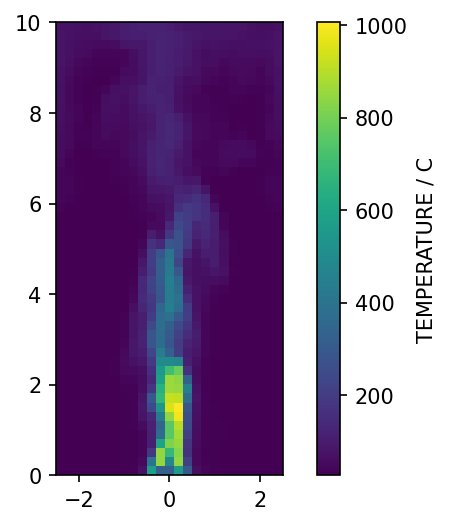

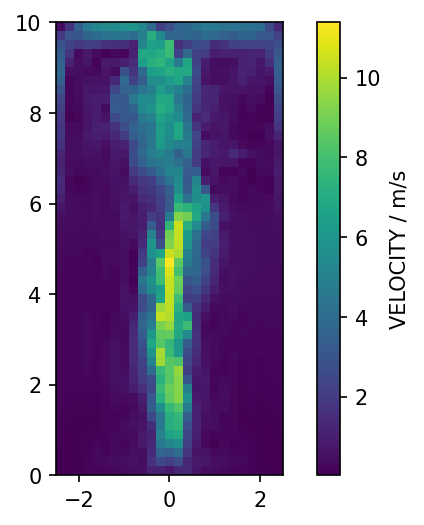

In [71]:
# Example for a multi plot
slice_n = len(sim.slices)
it = sim.slices[0].get_nearest_timestep(7.5)
for i in range(slice_n):
    plt.imshow(sim.slices[i][0].data[it].T,
               origin='lower', 
               extent=slice.extent.as_list())
    q = sim.slices[i].quantity.quantity
    u = sim.slices[i].quantity.unit
    plt.colorbar(label=f"{q} / {u}")
    plt.show()